In [1]:
import numpy as np
import pandas as pd
import functions.multi_occupation_network as multi_occupation_network
import matplotlib.pyplot as plt
from  functions.network_figures import bar_plot

# Calibration Excersize 2: One Occupation Per Sector

Suppose there is one type of labor specific to each sector, in other words that $\mathcal{O}=J$. We calibrate our model to mathc BEA input-output tables, and treat the residual, the part of production not accounted for by intermediate inputs, as the labor elasticity. 

In [2]:
A_spec = 1
data_dir = '../data/clean/'
dfTau = pd.read_csv(data_dir + 'tau_2021.csv').sort_values(by=['short_names'])
dfA      = pd.read_csv(data_dir + f'A{A_spec}.csv')
sectors = dfA['short_names']
dfDemand  = pd.read_csv(data_dir + 'demand_tab.csv')
dfLshare = pd.read_csv(data_dir + 'labor_tab.csv')
dfLabor_market_yearly= pd.read_csv(data_dir + 'uvh_annual_updated.csv')
dfLabor_market_yearly = dfLabor_market_yearly.sort_values(by=['Year', 'short_names'])
dfLabor_market_yearly = dfLabor_market_yearly.dropna(axis=0)
dfLabor_market_yearly = dfLabor_market_yearly[dfLabor_market_yearly['Year'] == 2021]
dfMatching_params = pd.read_csv(data_dir + 'matching_param_estimates.csv')
shares = pd.read_csv(data_dir + 'energy_capital_shares.csv')

In [3]:
# reformatting parameters
Omega = np.array(dfA.iloc[:, 1:], dtype='float64')
# rescale based on energy shares
rescaler = np.matrix(1 - shares['Capital share'] - shares['Energy share'])
J = Omega.shape[0]
Omega = np.multiply(Omega, (np.repeat(rescaler, J)).reshape(J, J))
Psi = np.linalg.inv(np.eye(Omega.shape[0])-Omega)
O = J

epsN = np.diag(np.array(dfLshare[f'labor_elasticity{A_spec}'], dtype='float64'))
epsN = np.multiply(epsN, rescaler)
epsD = np.array(dfDemand['demand_elasticity']).reshape((J,1))
epsK = np.matrix(shares[['Capital share', 'Energy share']])

K = epsK.shape[1]

θ = dfLabor_market_yearly['Tightness'] 
curlyQ = -np.diag(dfMatching_params['unemployment_elasticity'])
curlyF =  np.eye(J) + curlyQ
curlyT = np.diag(dfTau['Tau'])
curlyL = np.eye(J)

In [4]:
np.sum(Omega, axis=1).flatten() + np.sum(epsN, axis=1).flatten() + np.sum(epsK, axis=1).flatten()

matrix([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

First, we define the shocks we are interested in to allow us to easily change these in the future, that is we define the vectors $d\log\bm{A}$ and $d\log\bm{H}$.

In [5]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O, 1))
dlog_K = np.zeros((K, 1))
dlog_K[0, 0] = 0.01

We assume Cobb-Douglas production and preferences.

In [6]:
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
dlog_epsK = np.zeros_like(epsK)

We need to make some assumption about how wages change. We begin by assuming that nominal wages follow the Hulten case.

In [7]:
#epsW_A = np.zeros((O,J))
gamma_A = 1
gamma_H = 1
gamma_K = 1
epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFunc(gamma_A, gamma_H, gamma_K, Psi, curlyL, epsN, epsK)

In [8]:
epsW_K

matrix([[0.3583897 , 0.03703481],
        [0.29464196, 0.03559635],
        [0.44616546, 0.01778404],
        [0.24738884, 0.02227904],
        [0.41875901, 0.04502807],
        [0.14542588, 0.01284882],
        [0.47211431, 0.01053203],
        [0.62044511, 0.03649225],
        [0.50253147, 0.03996618],
        [0.2044973 , 0.02163052],
        [0.22207712, 0.01871221],
        [0.33791961, 0.03581903],
        [0.36637242, 0.14599153]])

In [9]:
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)

With these pieces in hand, we can now estimate responses to tightness. For details, see the multiple occupations example code.

In [10]:
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
dlog_theta

matrix([[ 5.20417043e-18],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [-3.46944695e-18],
        [ 0.00000000e+00],
        [ 1.73472348e-18],
        [ 6.93889390e-18],
        [ 0.00000000e+00],
        [-1.73472348e-18],
        [-3.46944695e-18],
        [-1.73472348e-18],
        [ 0.00000000e+00],
        [ 0.00000000e+00]])

In [11]:
dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
dlog_y

matrix([[0.0035839 ],
        [0.00294642],
        [0.00446165],
        [0.00247389],
        [0.00418759],
        [0.00145426],
        [0.00472114],
        [0.00620445],
        [0.00502531],
        [0.00204497],
        [0.00222077],
        [0.0033792 ],
        [0.00366372]])

In [12]:
num=0
dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_wR, dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
dlog_p

matrix([[ 0.00000000e+00],
        [ 6.37477416e-04],
        [-8.77757583e-04],
        [ 1.11000858e-03],
        [-6.03693108e-04],
        [ 2.12963815e-03],
        [-1.13724609e-03],
        [-2.62055408e-03],
        [-1.44141769e-03],
        [ 1.53892393e-03],
        [ 1.36312580e-03],
        [ 2.04700903e-04],
        [-7.98272170e-05]])

We can check labor market clearing holds.

In [13]:
multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF) - multi_occupation_network.LaborDemand(dlog_wR, dlog_y, dlog_epsN, curlyL)

matrix([[ 1.81541544e-18],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [-1.00174519e-18],
        [ 0.00000000e+00],
        [ 5.78939413e-19],
        [ 3.29648834e-18],
        [ 0.00000000e+00],
        [-1.05635373e-18],
        [-1.07038468e-18],
        [-6.55809919e-19],
        [ 0.00000000e+00],
        [ 0.00000000e+00]])

Aggregate output changes are.

In [14]:
dlog_aggY = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_aggY

matrix([[0.00349487]])

Since labor market frictions are the only source of inefficiency in our network economy, in the absence of labor market frictions our network economy is fully efficient. It is well known that Hulten's theorem holds in efficient network economies with Cobb-Douglas technology. We can therefore easily compare the implications of labor market frictions for aggregate output with the implications of the same technology shocks absent labor market frictions.  

In [15]:
epsD.T @ Psi @ dlog_A

matrix([[0.]])

## Calibration figures: Response to Technology Shock

### Aggregate importance of deviations from Hulten.

To analyse the quantitative importance of deviations from Hulten's theorem, below we vary $\gamma_A$ from 0 to 2, and plot the aggregate response to a 1\% shock to durable goods.

In [16]:
# Setting which sectors to shock, and getting the full name of the sector. 
sec_to_shock = 'dur'
# For reference, these are other sectors we can shock
print(sectors)
sec_dict = pd.read_excel("../data/update_raw/long_short_names_crosswalk.xlsx")
sec_full = sec_dict['Industry'][sec_dict['short_names'] == sec_to_shock].iloc[0].title()
print(f'the full name for {sec_to_shock} is {sec_full}')

0        accom
1        const
2          dur
3     edhealth
4          fin
5          gov
6         info
7       mining
8       nondur
9        other
10    profserv
11       trade
12       trans
Name: short_names, dtype: object
the full name for dur is Durable Goods Manufacturing


In [17]:
N = 1000
gamma_a_vec = np.linspace(0,2,N)
aggY_vec = np.zeros_like(gamma_a_vec)
dlog_A = np.zeros((J, 1))
dlog_A[np.where(sectors == sec_to_shock)] = 0.01 
dlog_H = np.zeros((O,1))
dlog_K = np.zeros((K, 1))
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)

for i in range(N):
    epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFunc(gamma_a_vec[i], 1, 1, Psi, curlyL, epsN, epsK)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
    dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    aggY_vec[i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)

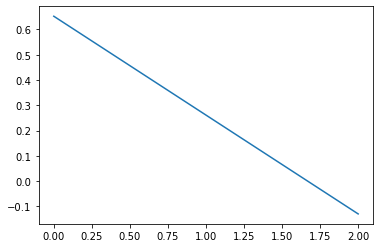

In [18]:
plt.plot(gamma_a_vec,100*aggY_vec)

Next, we plot responses of sectoral output to technology shocks assuming $\gamma_A = [0.9, 1, 1.1]$. 

In [19]:
gamma_A_vec = np.array([0.5,1,1.5])
sectorY_vec = np.zeros((J+1, 3))
occT_vec = np.zeros((O, 3))
occU_vec = np.zeros((O, 3))
for i in range(3):
    epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFunc(gamma_A_vec[i], 1, 1, Psi, curlyL, epsN, epsK)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
    occT_vec[:, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    occU_vec[:,i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

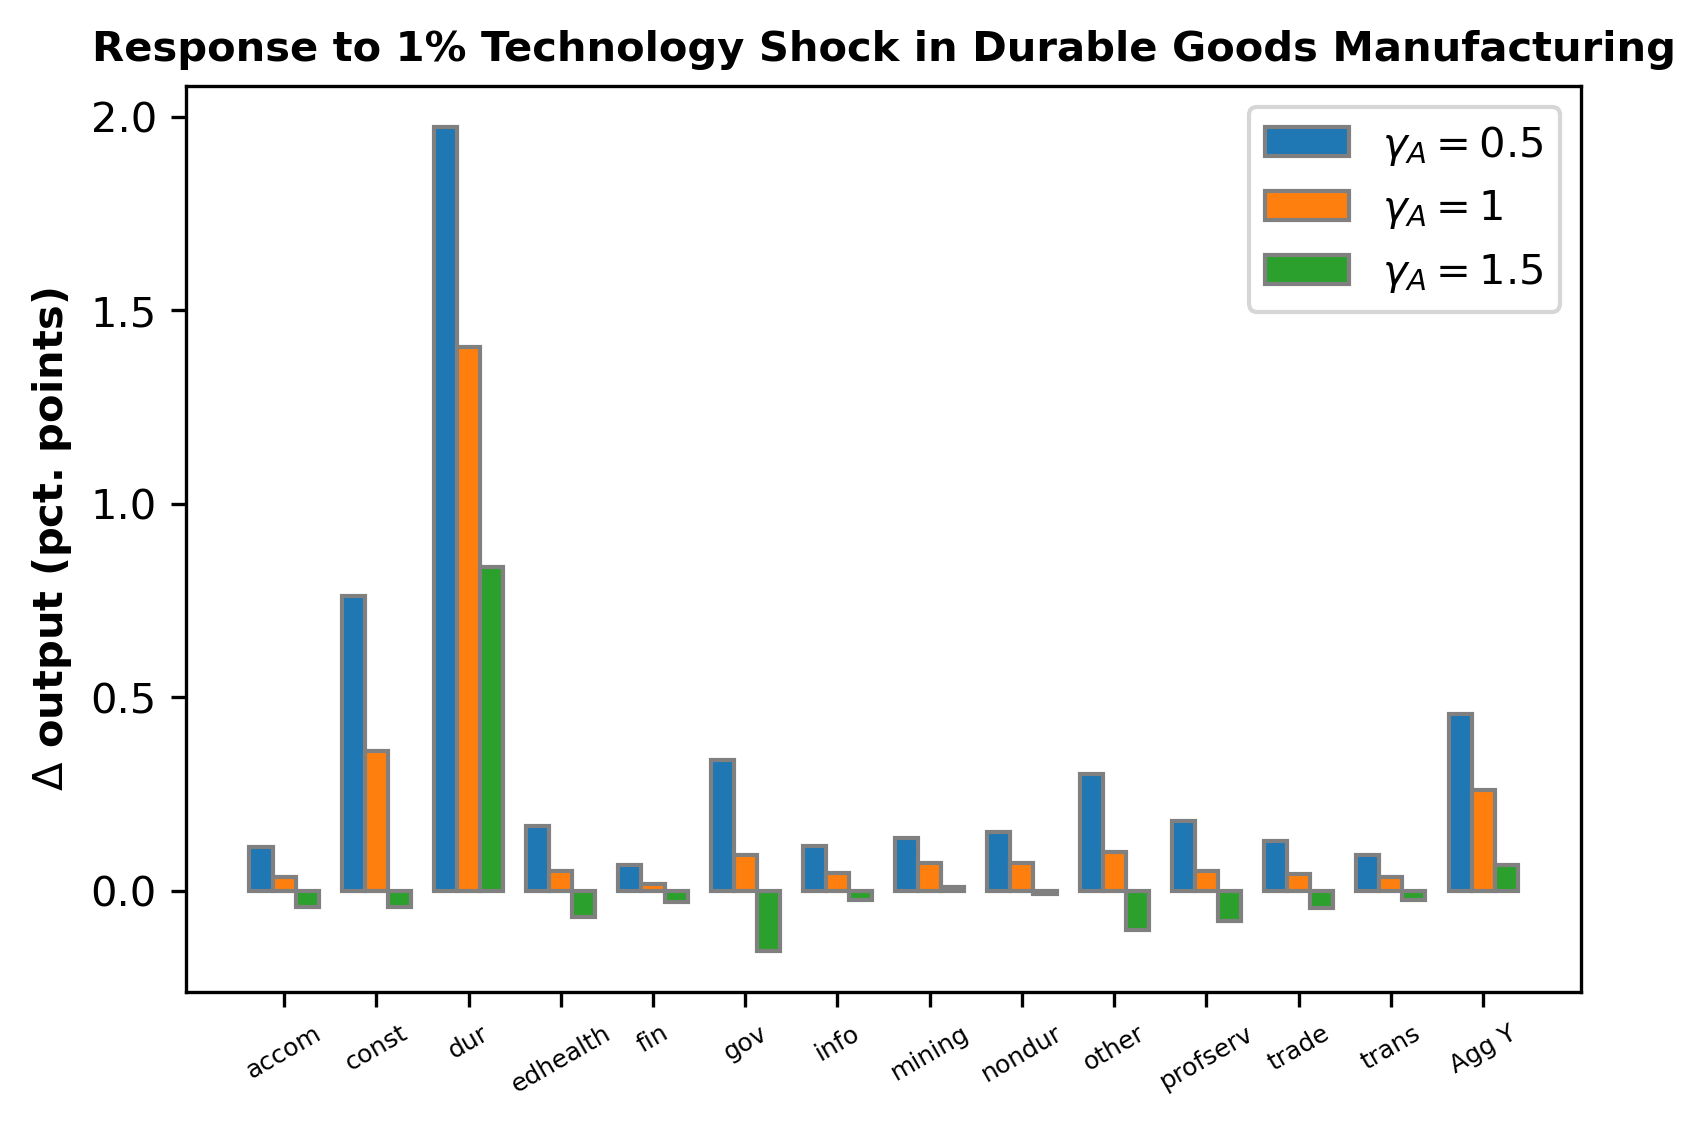

In [20]:
sector_names = list(dfA['short_names']) + ['Agg Y']
title = f'Response to 1% Technology Shock in {sec_full}'
xlab = ''
ylab = '$\Delta$ output (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_AshockY_calib2.png'
labels = ['$\gamma_{A} = 0.5$','$\gamma_{A} = 1$','$\gamma_{A} = 1.5$']
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

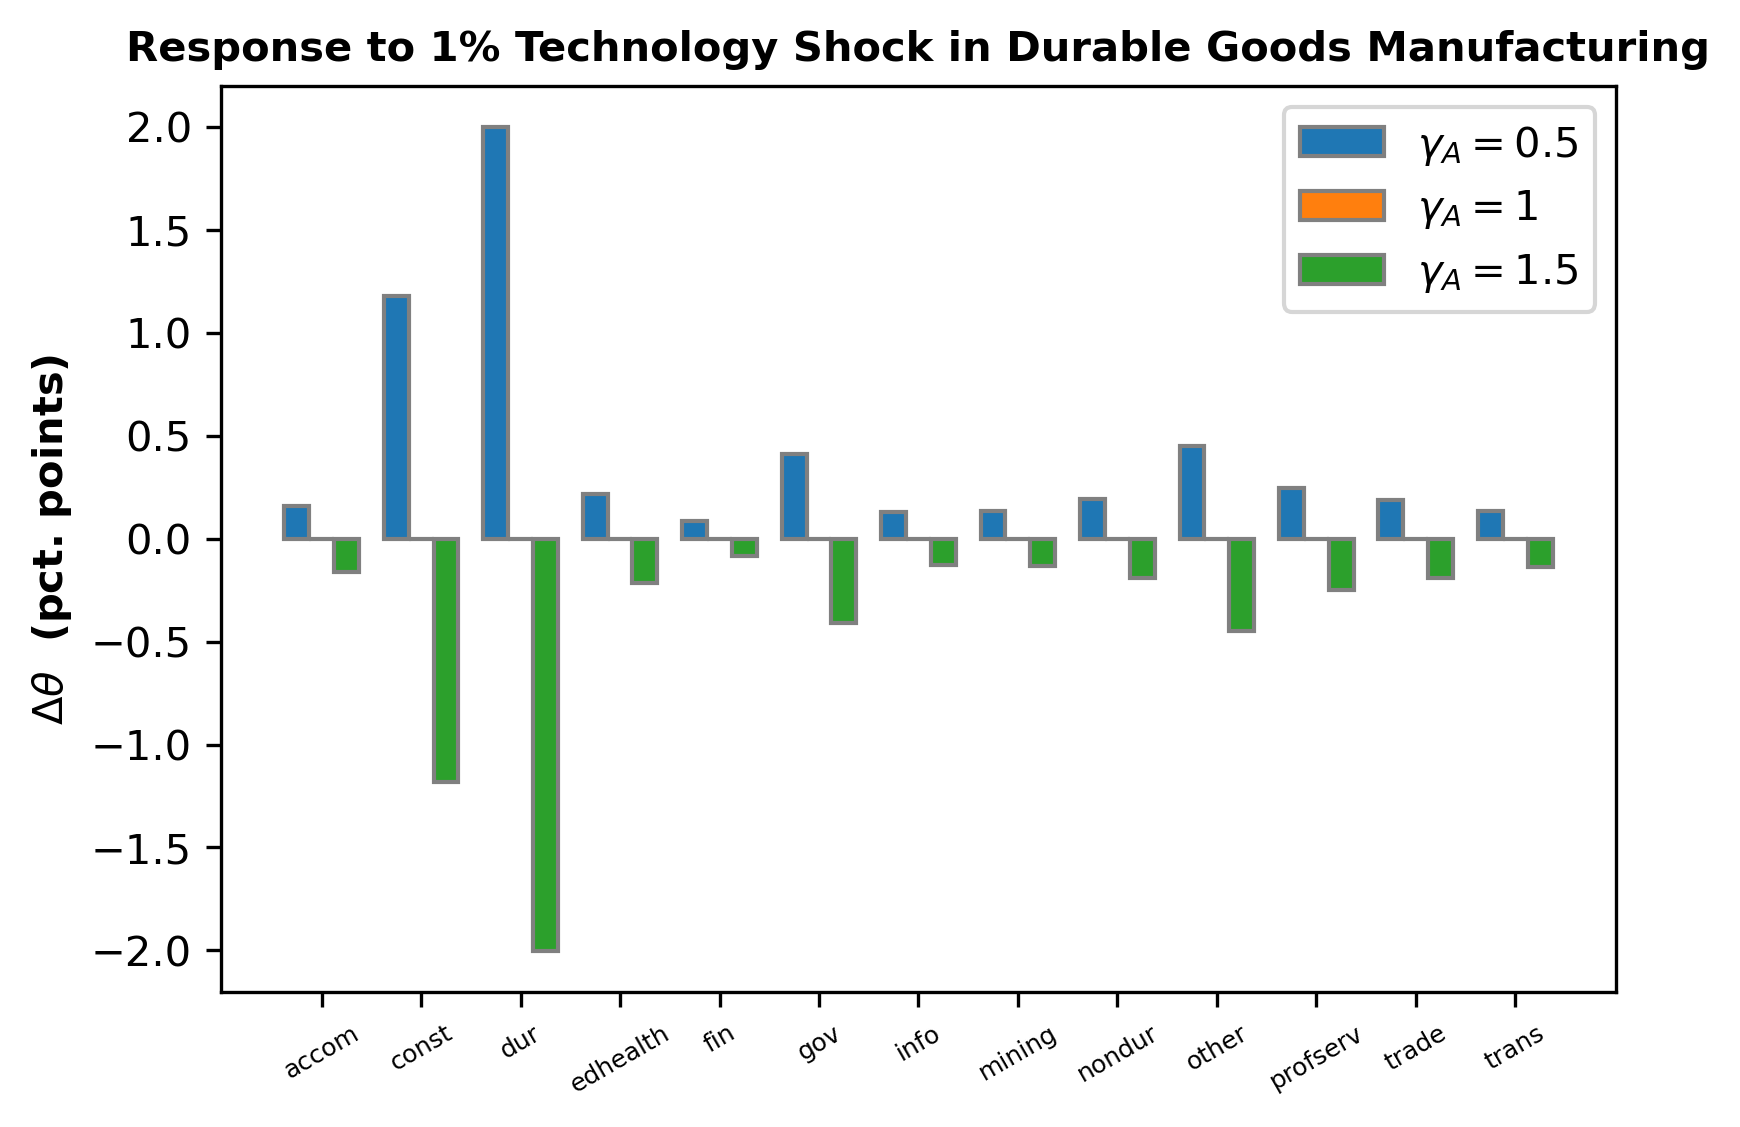

In [21]:
occupation_names = list(dfA['short_names'])
xlab = ''
ylab = '$\Delta \\theta$  (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_AshockT_calib2.png'
labels = ['$\gamma_{A} = 0.5$','$\gamma_{A} = 1$','$\gamma_{A} = 1.5$']
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

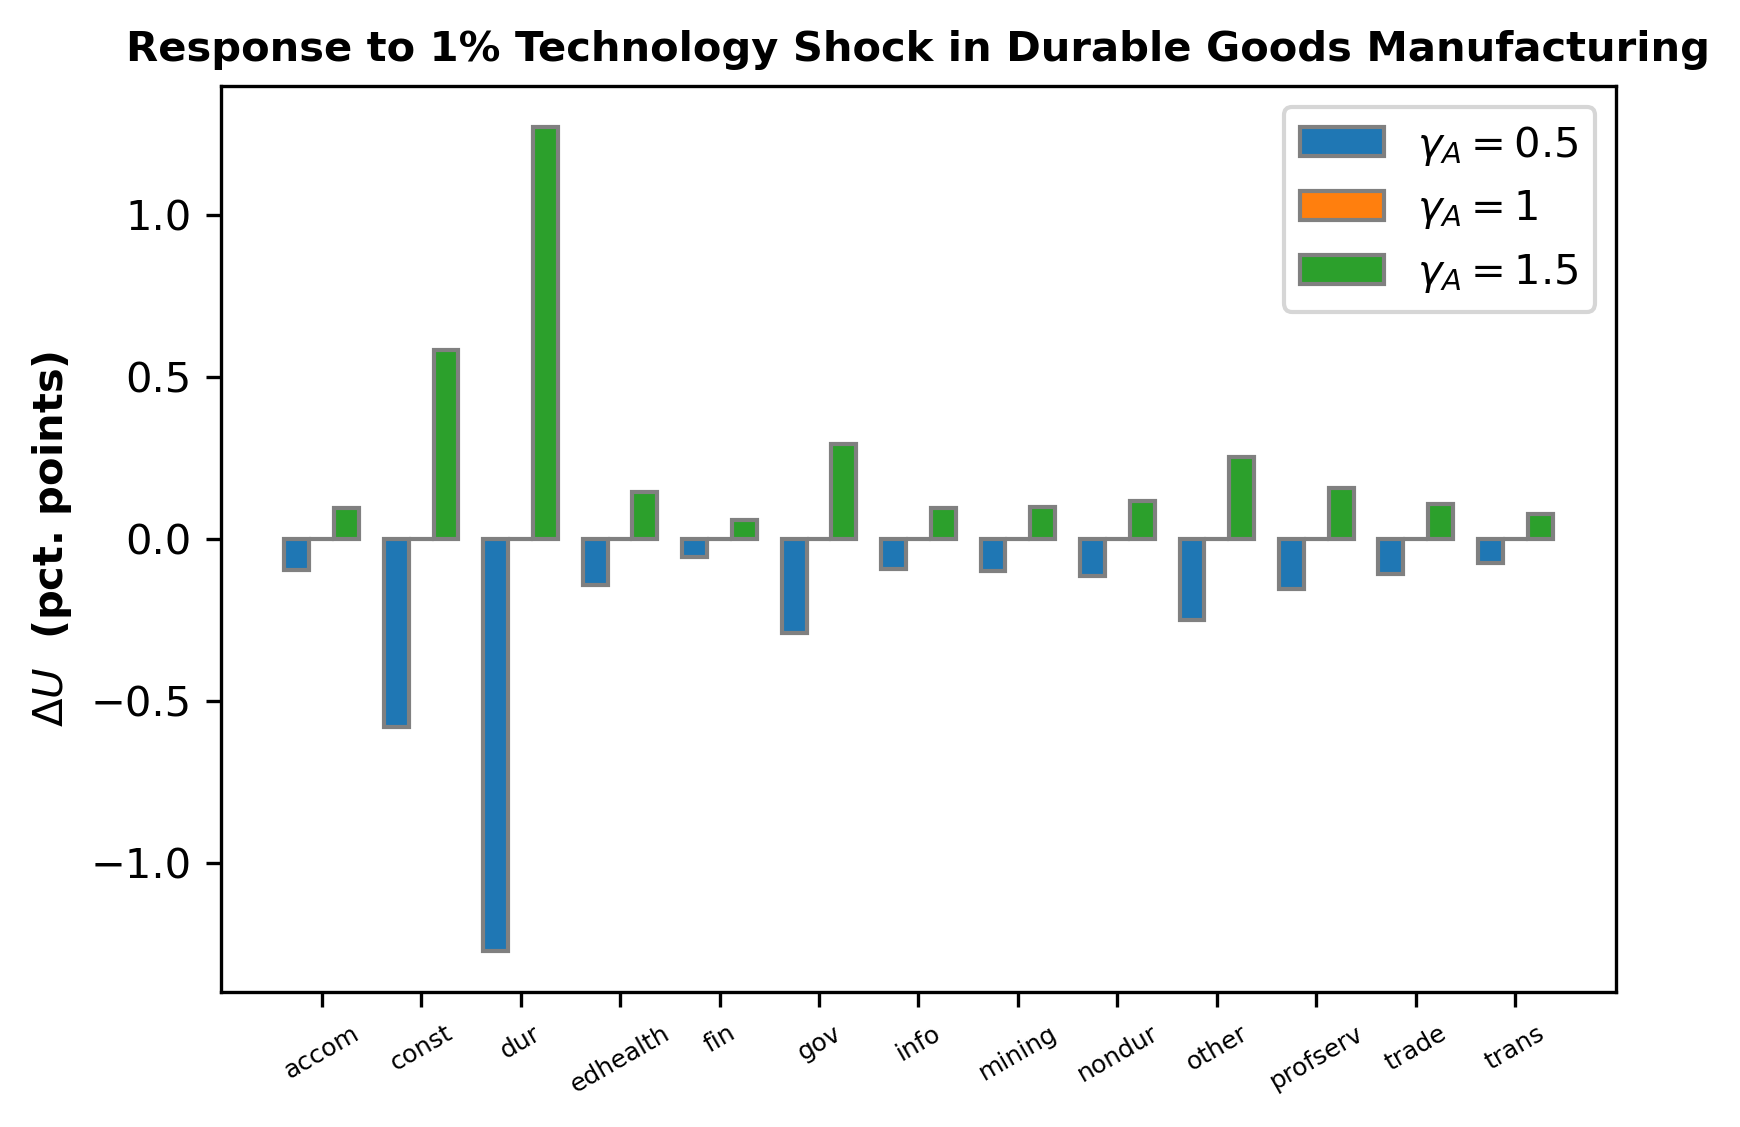

In [22]:
xlab = ''
ylab = '$\Delta U$  (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_AshockU_calib2.png'
labels = ['$\gamma_{A} = 0.5$','$\gamma_{A} = 1$','$\gamma_{A} = 1.5$']
bar_plot(100*occU_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

## Calibration Figures: Response to Labor Force Shock
We repeat the code above for the case of a shock to the size of the labor force, $d\log\bm{H}$.

In [23]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O,1))
dlog_K = np.zeros((K, 1))
dlog_H[2] = 0.01 
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)

In [24]:
gamma_H_vec = np.array([0.5,1,1.5])
sectorY_vec = np.zeros((J+1,3))
occT_vec = np.zeros((O,3))
occU_vec = np.zeros((O,3))
for i in range(3):
    epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFunc(1, gamma_H_vec[i], 1, Psi, curlyL, epsN, epsK)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
    occT_vec[:, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    occU_vec[:,i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

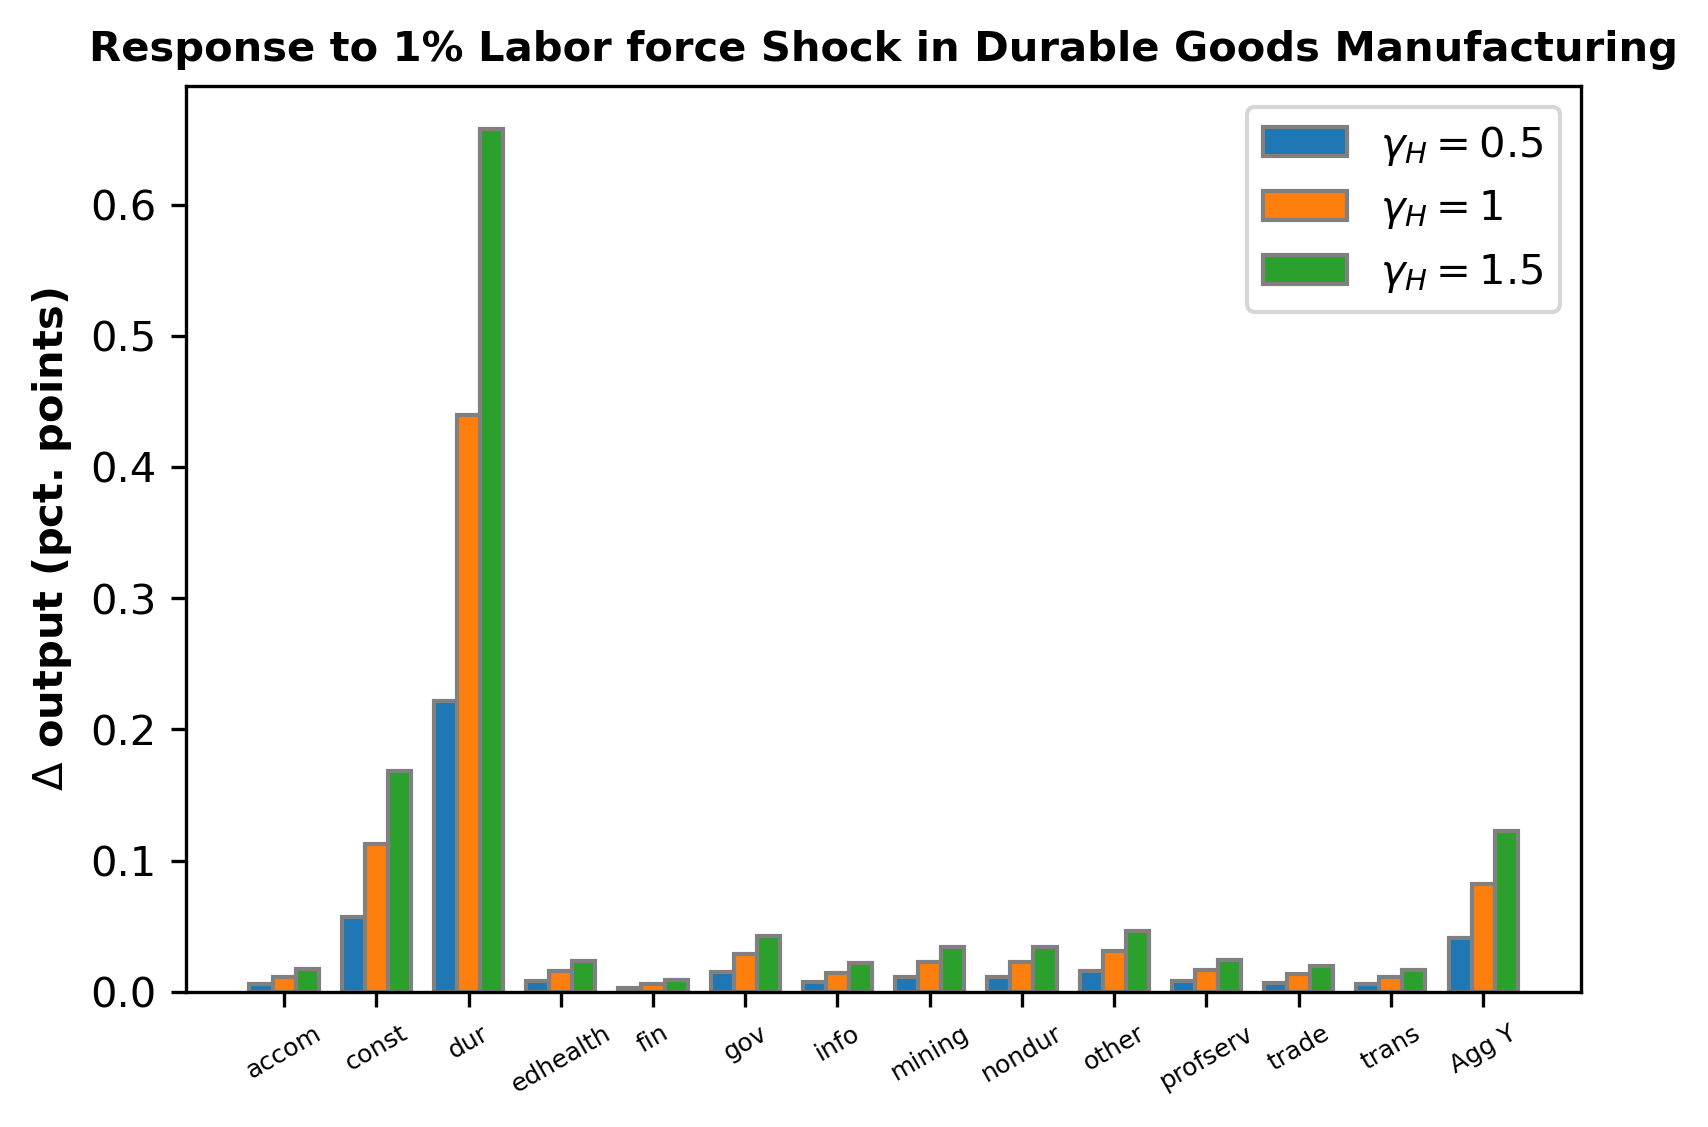

In [25]:
title = f'Response to 1% Labor force Shock in {sec_full}'
xlab = ''
ylab = '$\Delta$ output (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_HshockY_calib2.png'
labels = ['$\gamma_{H} = 0.5$','$\gamma_{H} = 1$','$\gamma_{H} = 1.5$']
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

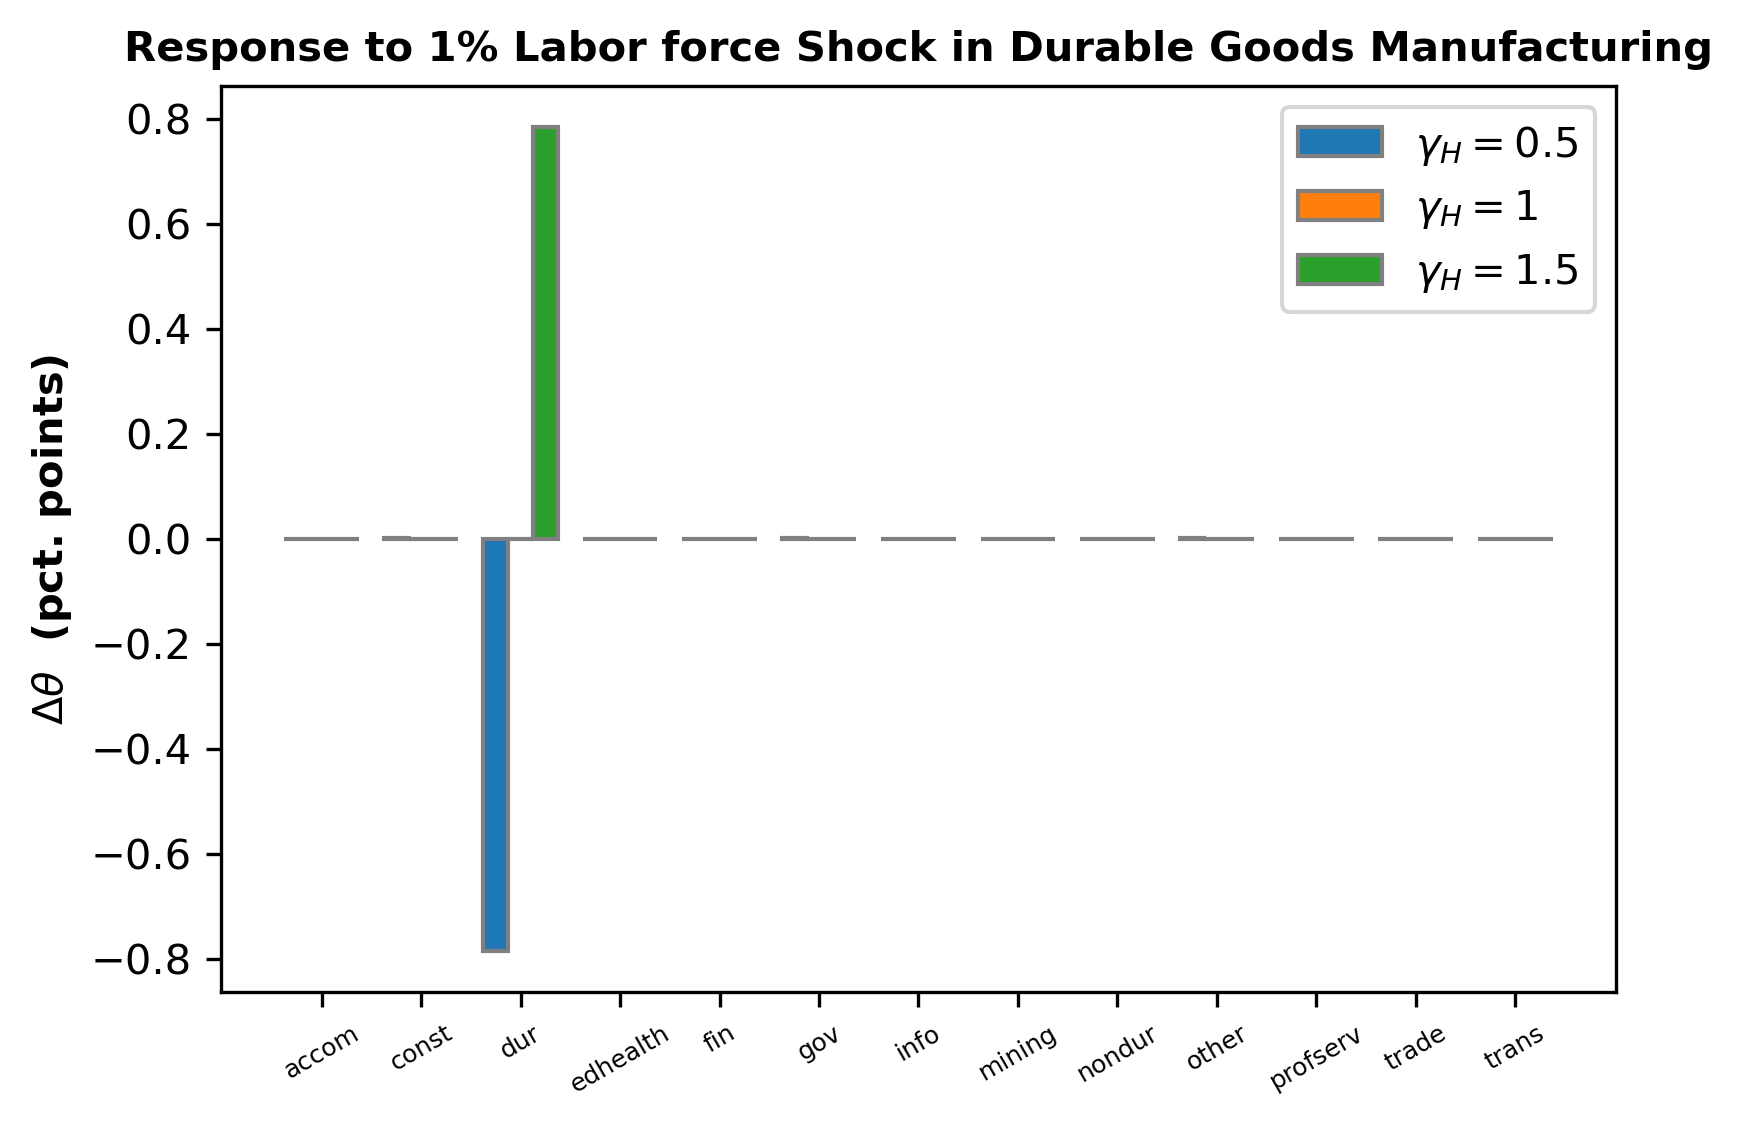

In [26]:
xlab = ''
ylab = '$\Delta \\theta$  (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_HshockT_calib2.png'
labels = ['$\gamma_{H} = 0.5$','$\gamma_{H} = 1$','$\gamma_{H} = 1.5$']
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

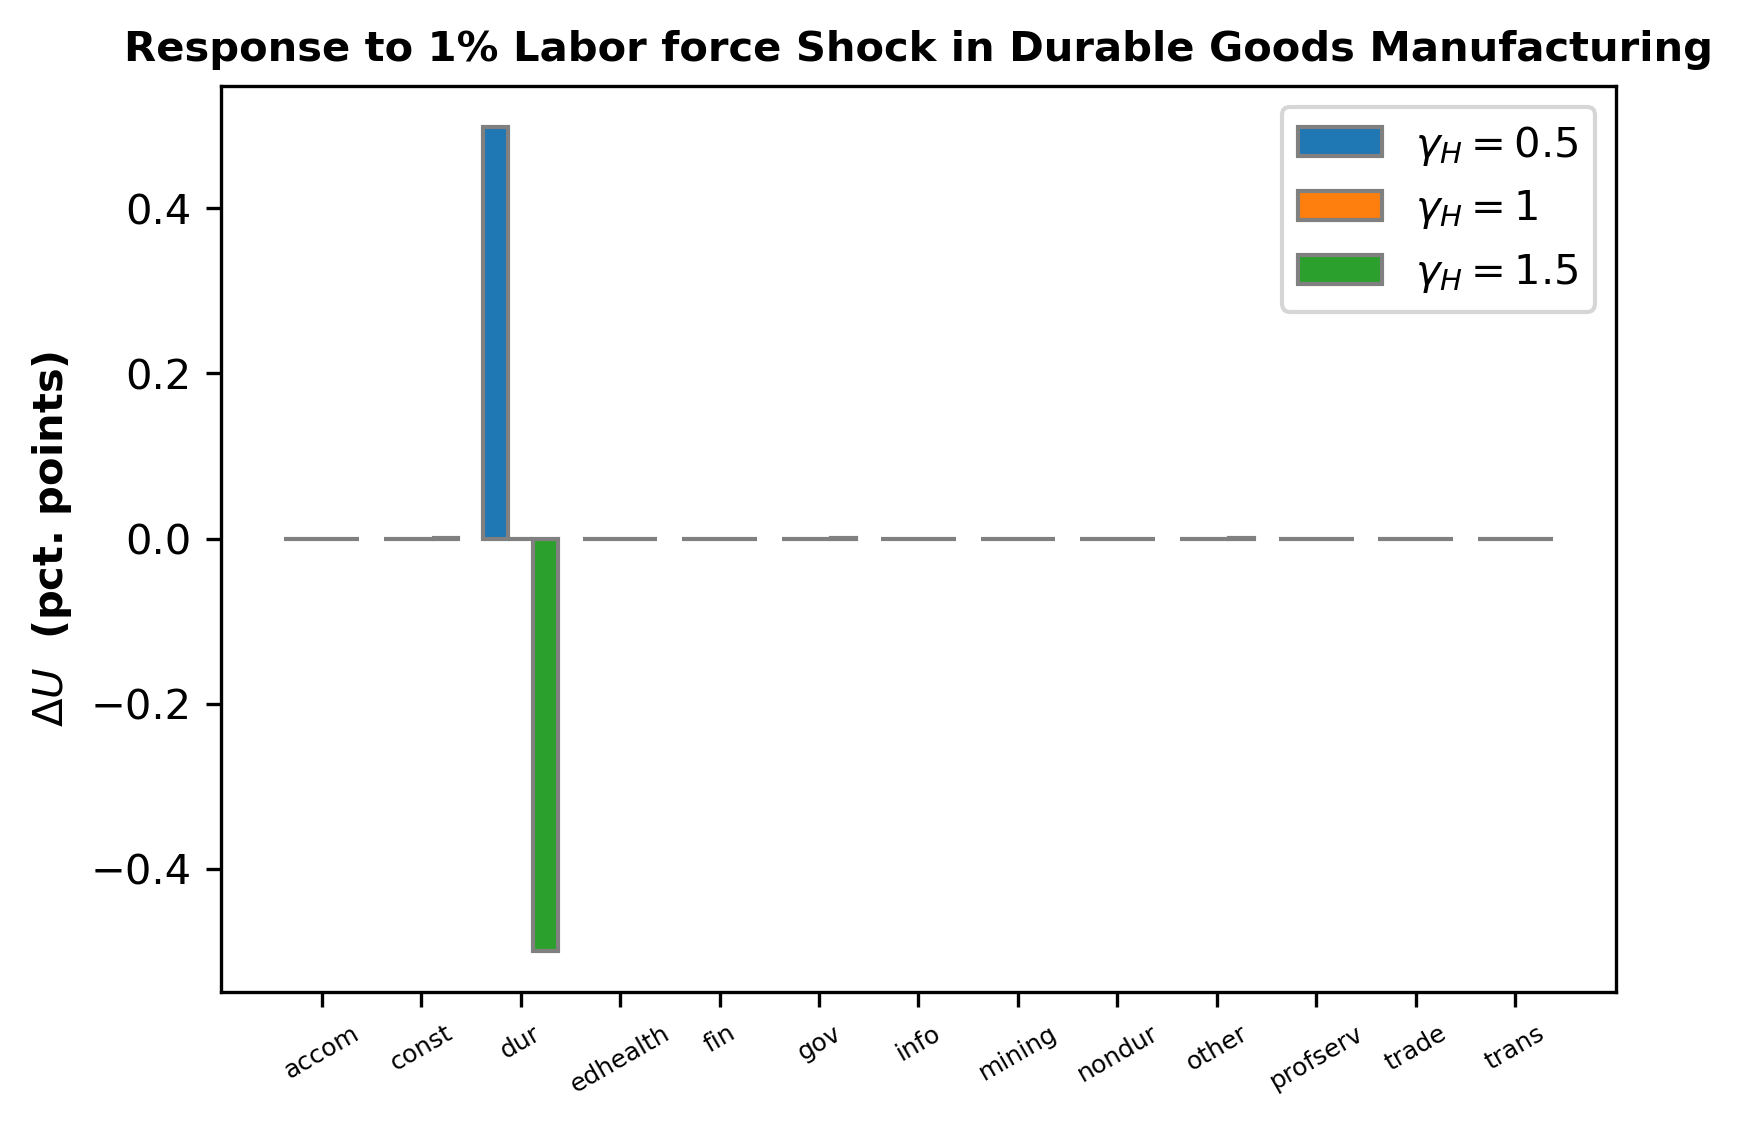

In [27]:
xlab = ''
ylab = '$\Delta U$  (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_HshockU_calib2.png'
labels = ['$\gamma_{H} = 0.5$','$\gamma_{H} = 1$','$\gamma_{H} = 1.5$']
bar_plot(100*occU_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

## Response to Energy Shocks

In [28]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O, 1))
dlog_K = np.zeros((K, 1))
dlog_K[1] = 0.01 
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)

In [29]:
gamma_K_vec = np.array([0.5, 1, 1.5])
sectorY_vec = np.zeros((J+1,len(gamma_K_vec)))
occT_vec = np.zeros((O, len(gamma_K_vec)))
occU_vec = np.zeros((O, len(gamma_K_vec)))
p_vec = np.zeros((J, len(gamma_K_vec)))
for i in range(len(gamma_K_vec)):
    epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=gamma_K_vec[i], Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
    occT_vec[:, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    num=0
    dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
    dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_wR, dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    p_vec[:, i] = dlog_p.flatten()
    occU_vec[:,i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

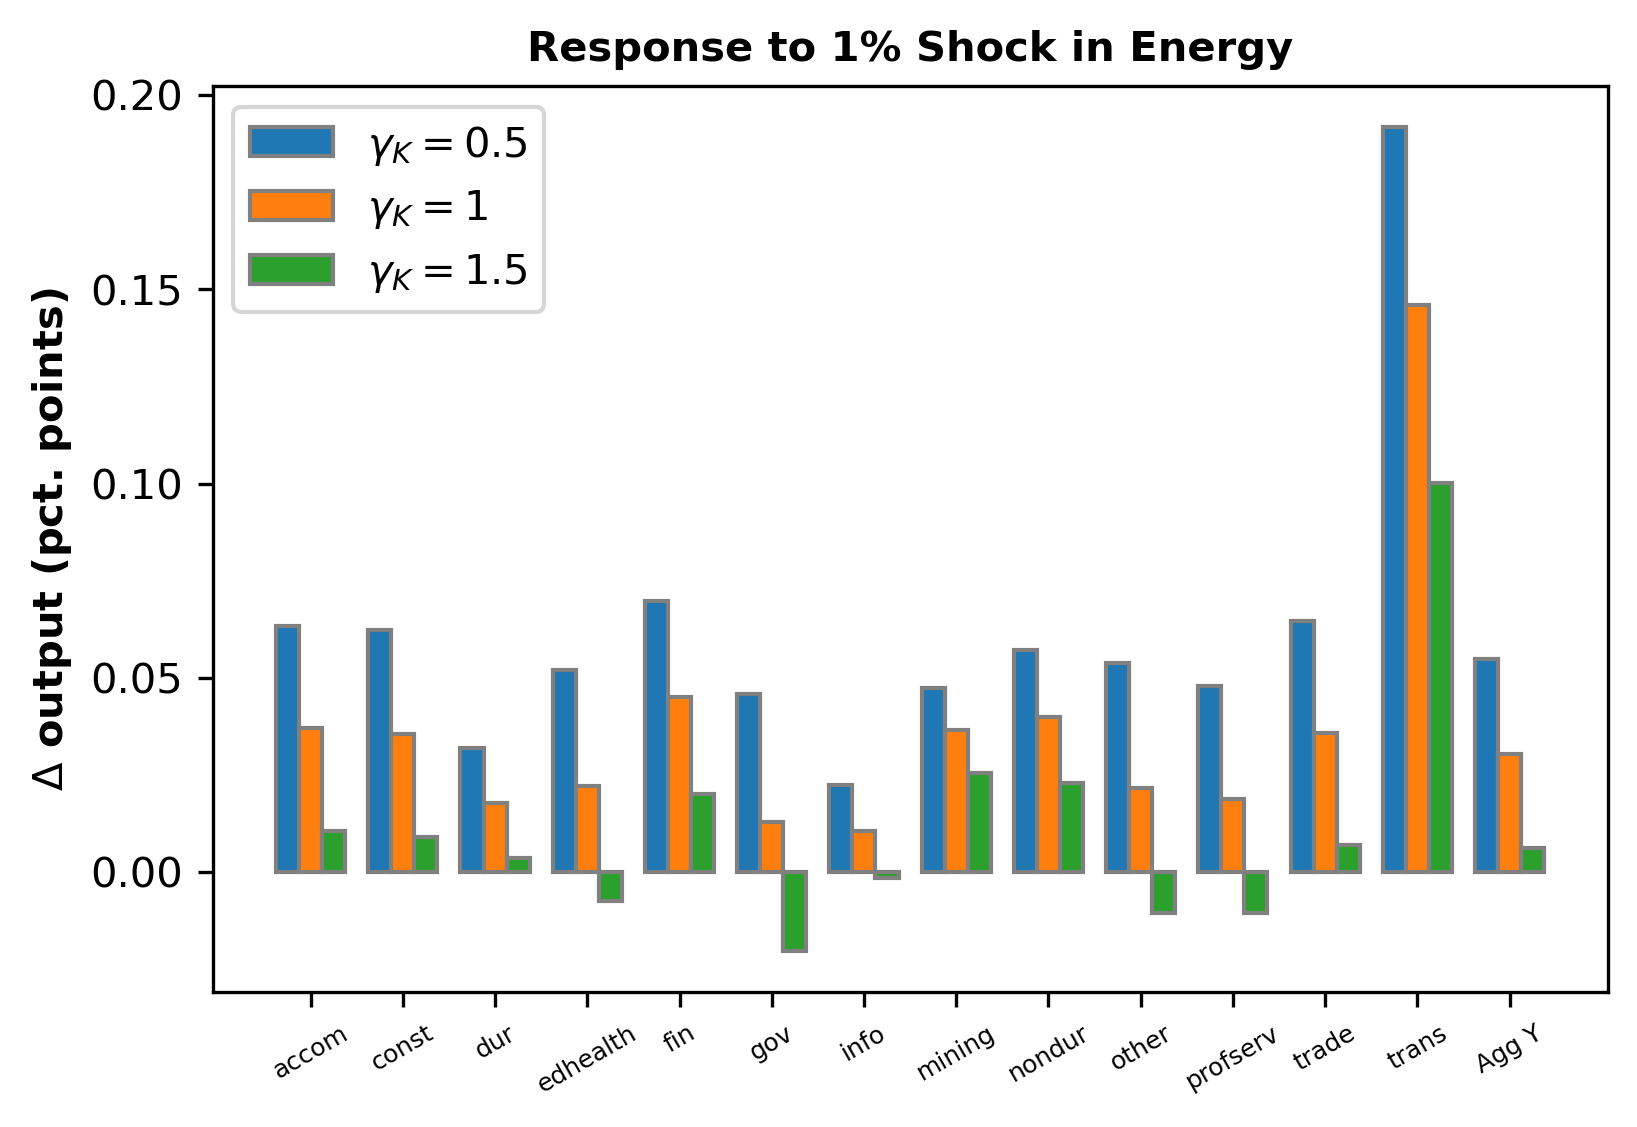

In [30]:
title = f'Response to 1% Shock in Energy'
xlab = ''
ylab = '$\Delta$ output (pct. points)'
save_path = f'../output/figures/energy_A{A_spec}_KshockY_calib2.png'
labels = ['$\gamma_{K} = 0.5$', '$\gamma_{K} = 1$', '$\gamma_{K} = 1.5$']
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

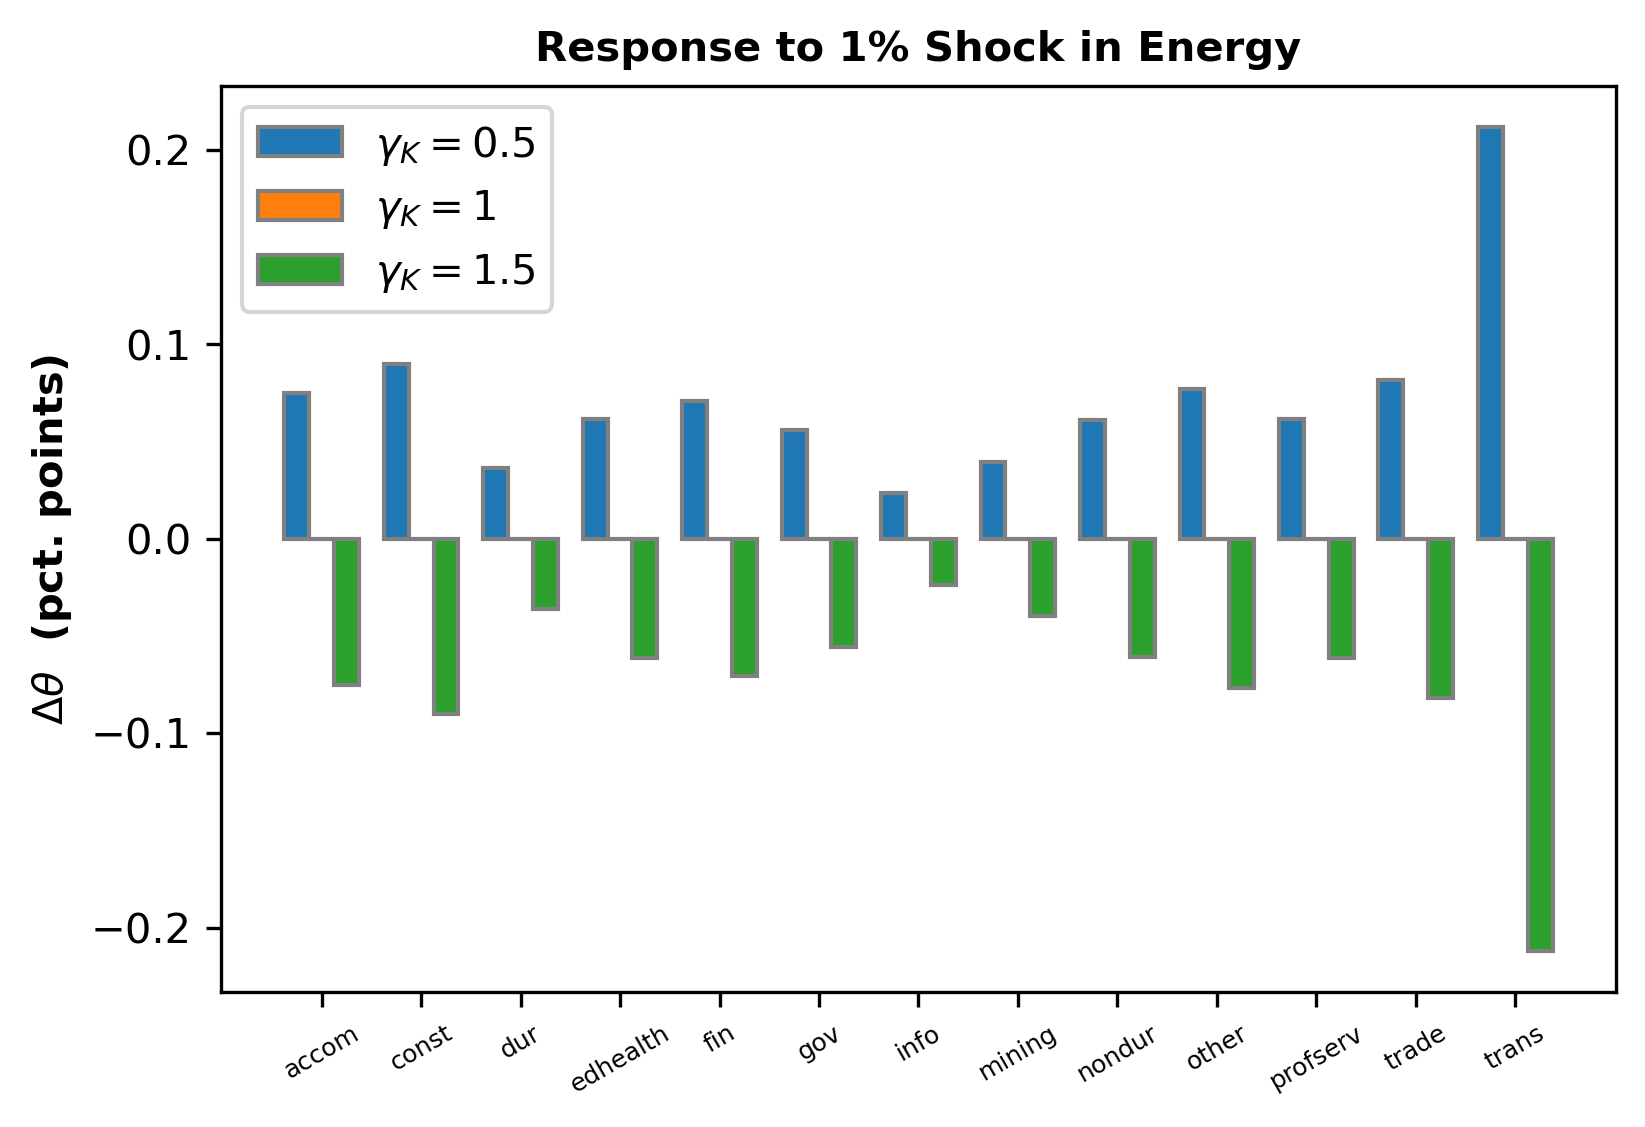

In [31]:
xlab = ''
ylab = '$\Delta \\theta$  (pct. points)'
save_path = f'../output/figures/energy_A{A_spec}_KshockT_calib2.png'
labels = ['$\gamma_{K} = 0.5$', '$\gamma_{K} = 1$', '$\gamma_{K} = 1.5$']
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

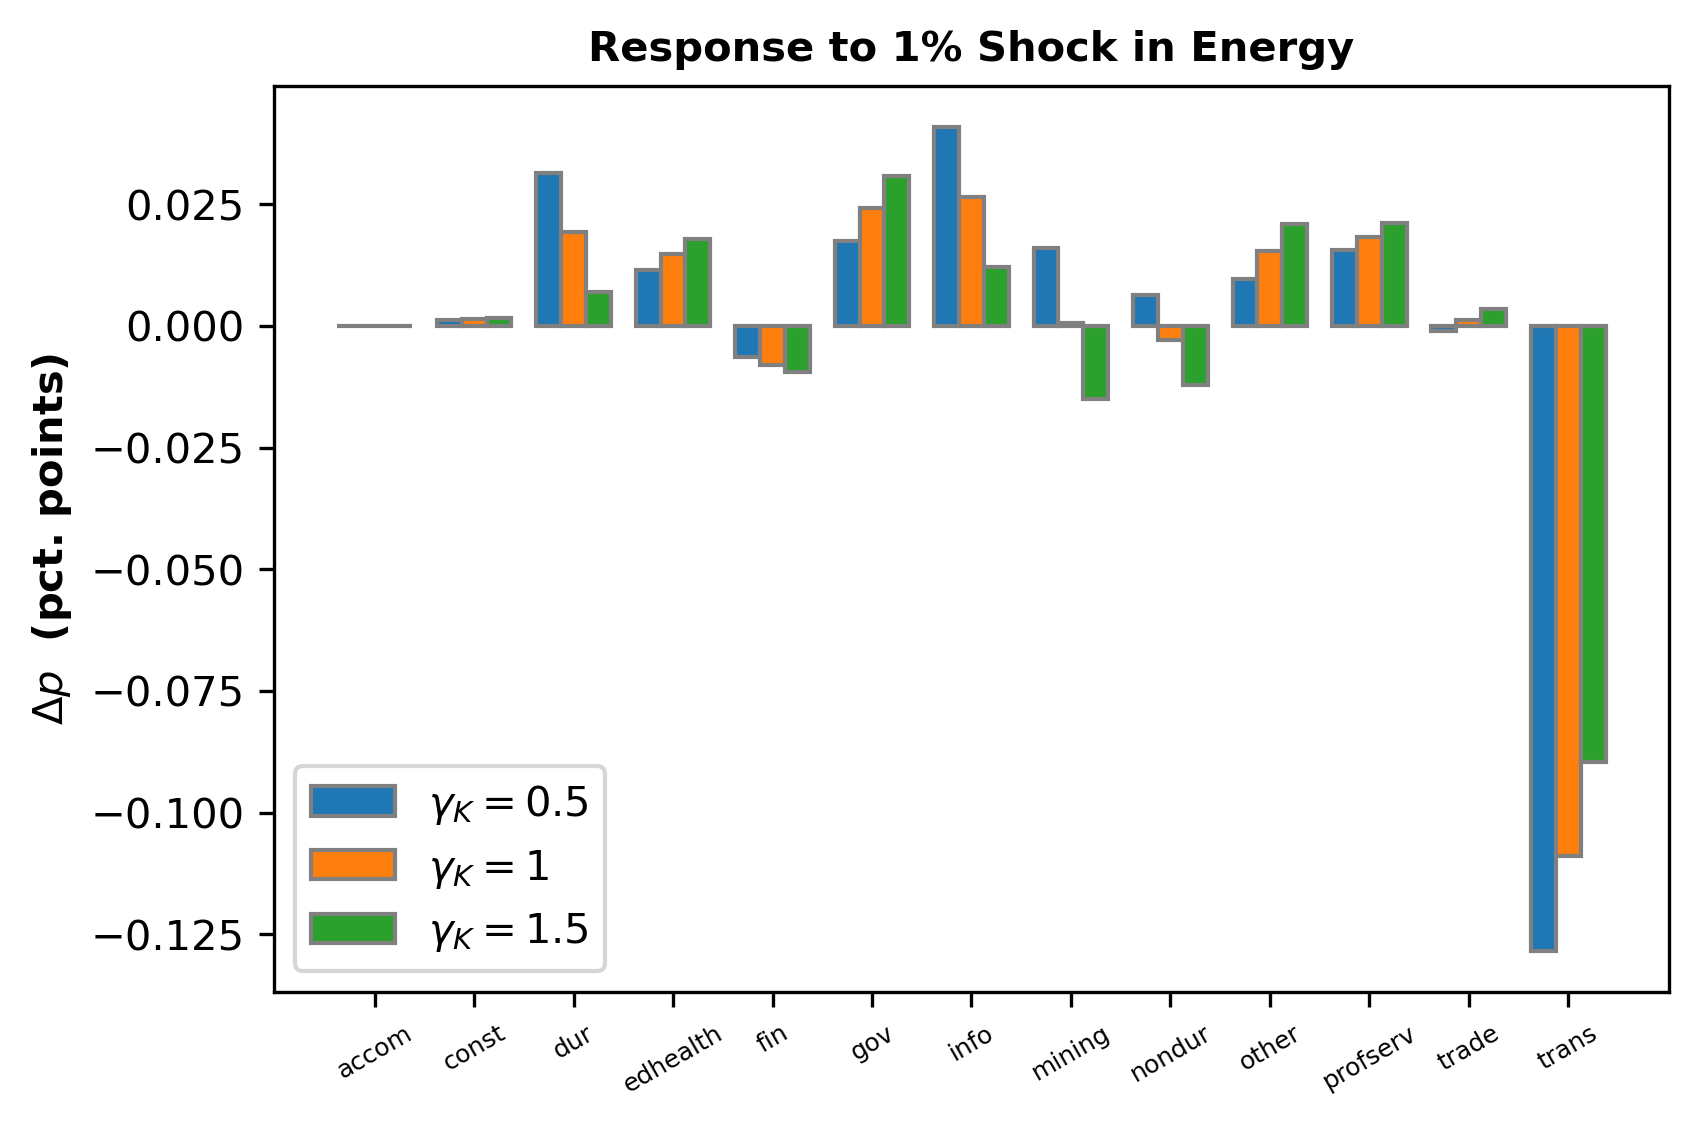

In [32]:
xlab = ''
ylab = '$\Delta p$  (pct. points)'
save_path = f'../output/figures/energy_A{A_spec}_KshockP_calib2.png'
labels = ['$\gamma_{K} = 0.5$', '$\gamma_{K} = 1$', '$\gamma_{K} = 1.5$']
bar_plot(100*p_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

## Wage changes proportional to marginal product of labor


In [33]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O,1))
dlog_K = np.zeros((K, 1))
dlog_K[1] = 0.01
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
#epsW_A = np.zeros((O,J))
gamma = 0.5
epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFuncMP(gamma, Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL)
epsW_K

matrix([[9.60270987e-04, 9.57436963e-05],
        [2.24776311e-03, 2.21739270e-04],
        [3.67722593e-03, 1.77951997e-04],
        [2.23830794e-03, 2.01286546e-04],
        [3.50824990e-03, 3.70320480e-04],
        [3.99583502e-03, 3.49515303e-04],
        [4.55530796e-03, 1.62946925e-04],
        [1.70423477e-03, 1.05868066e-04],
        [4.03714931e-03, 3.25693907e-04],
        [1.20953392e-02, 1.17085497e-03],
        [1.03103758e-02, 8.85011940e-04],
        [2.11112515e-03, 2.19871412e-04],
        [5.74639978e-04, 1.80961351e-04]])

In [34]:
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
dlog_wR

matrix([[9.57436963e-07],
        [2.21739270e-06],
        [1.77951997e-06],
        [2.01286546e-06],
        [3.70320480e-06],
        [3.49515303e-06],
        [1.62946925e-06],
        [1.05868066e-06],
        [3.25693907e-06],
        [1.17085497e-05],
        [8.85011940e-06],
        [2.19871412e-06],
        [1.80961351e-06]])

In [35]:
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
dlog_theta

matrix([[0.00148817],
        [0.00178284],
        [0.00071379],
        [0.00121211],
        [0.00139855],
        [0.00108928],
        [0.00046617],
        [0.00078655],
        [0.0012078 ],
        [0.00147641],
        [0.00118427],
        [0.00161919],
        [0.00422528]])

In [36]:
num=0
dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_wR, dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
dlog_p

matrix([[ 0.        ],
        [-0.00076972],
        [-0.00034494],
        [-0.0006809 ],
        [-0.00082708],
        [-0.00065453],
        [-0.00022277],
        [-0.00047254],
        [-0.00062901],
        [-0.00071261],
        [-0.00062365],
        [-0.00080825],
        [-0.00225648]])

In [37]:
dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
dlog_y

matrix([[0.00089213],
        [0.00088204],
        [0.00045545],
        [0.00080653],
        [0.00094159],
        [0.0007755 ],
        [0.00033964],
        [0.00058132],
        [0.00073874],
        [0.00083631],
        [0.00075263],
        [0.00092502],
        [0.00237146]])

In [38]:
# Setting which sectors to shock, and getting the full name of the sector. 
sec_to_shock = 'dur'
# For reference, these are other sectors we can shock
print(sectors)
sec_dict = pd.read_excel("../data/update_raw/long_short_names_crosswalk.xlsx")
sec_full = sec_dict['Industry'][sec_dict['short_names'] == sec_to_shock].iloc[0].title()
print(f'the full name for {sec_to_shock} is {sec_full}')

gamma = np.array([0.5, 0.99,0.999999999])
sectorY_vec = np.zeros((J+1, 3))
occT_vec = np.zeros((O, 3))
occU_vec = np.zeros((O, 3))
for i in range(3):
    epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFuncMP(gamma[i],  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
    occT_vec[:, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    occU_vec[:,i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

0        accom
1        const
2          dur
3     edhealth
4          fin
5          gov
6         info
7       mining
8       nondur
9        other
10    profserv
11       trade
12       trans
Name: short_names, dtype: object
the full name for dur is Durable Goods Manufacturing


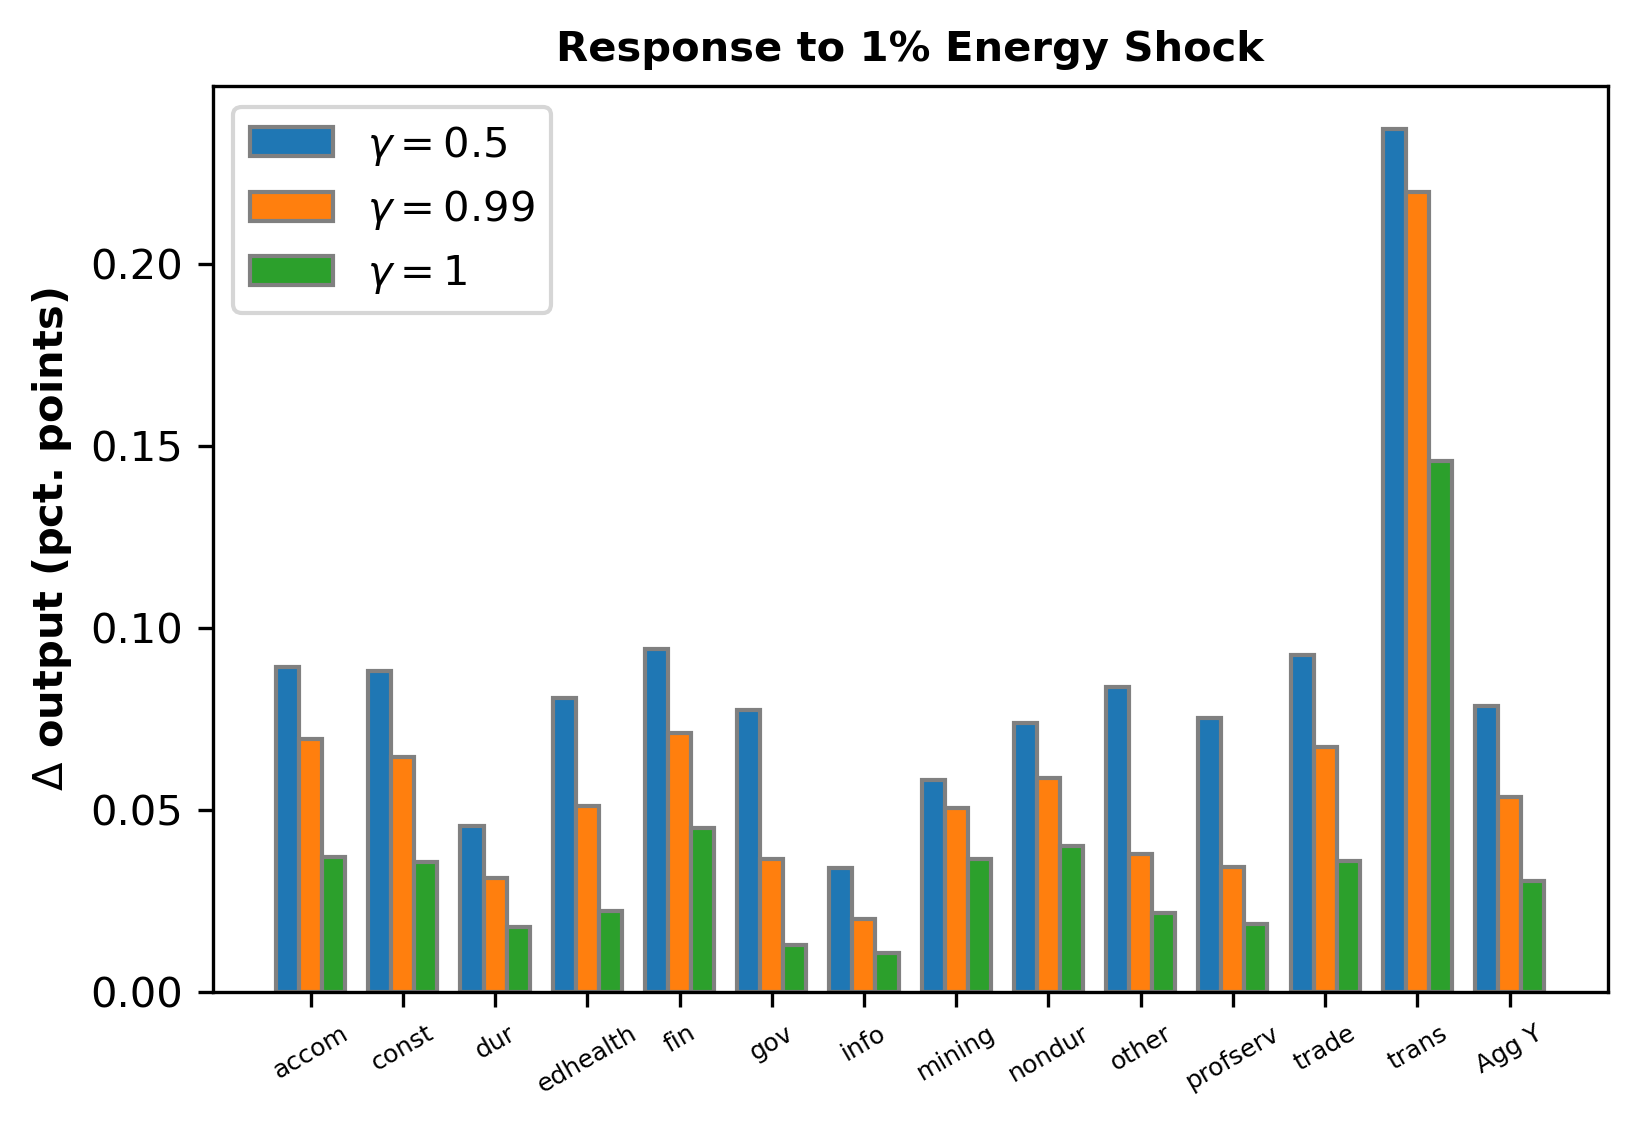

In [39]:
sector_names = list(dfA['short_names']) + ['Agg Y']
title = f'Response to 1% Energy Shock'
xlab = ''
ylab = '$\Delta$ output (pct. points)'
save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_EshockY_MP_calib2.png'
labels = ['$\gamma = 0.5$','$\gamma = 0.99$','$\gamma = 1$']
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

## Nominally rigid wages

What if instead of assuming wages respond proportionally to $\bm{\mathcal{L} \Psi}$ we assume that wages are nominally fully rigid. In this case, wage changes satisfy
\begin{align*}
    d\log \bm{w} - \bm{\mathcal{L}} d\log\bm{p} = - \bm{\mathcal{L}}d\log\bm{p}
\end{align*}
Where, up to a numeraire, $d\log\bm{p}$ satisfies 
\begin{align*}
    \left(\bm{I}-\bm{\mathcal{L}\Psi \varepsilon^f_N}\right)\bm{\mathcal{F}}\left(\bm{\Psi \varepsilon^f_N \mathcal{QT}}\right)^{-1} d\log\bm{p} = \left(\bm{I}-\bm{\mathcal{L}\Psi \varepsilon^f_N}\right) d\log\bm{H} - \left(\bm{I}-\bm{\mathcal{L}\Psi \varepsilon^f_N}\right)\bm{\mathcal{F}}\left(\bm{\Psi \varepsilon^f_N \mathcal{QT}}\right)^{-1}\bm{\Psi} d\log \bm{A}
\end{align*}
In principle, once we have picked a numeraire, we could write closed form expressions for $\Lambda_A$ and $\Lambda_H$ in terms of the parameters of the model. But these expressions will be complicated and doing so is unnecessary for the calibration. 

In [40]:
num = 0
dlog_A = np.zeros((J, 1))
dlog_A[2] = -0.01 
dlog_H = np.zeros((O,1))
dlog_wR = multi_occupation_network.NomRigWageFunc(dlog_A, dlog_H, Psi, epsN, curlyQ, curlyF, curlyT, curlyL, num)
dlog_wR

AttributeError: module 'functions.multi_occupation_network' has no attribute 'NomRigWageFunc'

We can work out tightness now that we have wages.

In [ ]:
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN)
dlog_theta

TypeError: ThetaFunc() missing 2 required positional arguments: 'epsN' and 'epsK'

We can check the code is working by comparing how price change calculated two different ways.

In [ ]:
dlog_p_array = np.ones((dlog_A.shape[0], 3))
dlog_p2 = multi_occupation_network.PriceFunc(dlog_A, dlog_wR, dlog_theta, Psi, curlyQ, epsN, curlyT, curlyL, num=num)
dlog_p = multi_occupation_network.NomRigPriceFunc(dlog_A, dlog_H, Psi, epsN, curlyQ, curlyF, curlyT, curlyL, num)
dlog_p_array[:,0] = dlog_p.flatten()
dlog_p_array[:,1] = dlog_p2.flatten()
dlog_p_array[:,2] = dlog_p.flatten() - dlog_p2.flatten()
dlog_p_array

We can now work out output.

In [ ]:
dlog_y = multi_occupation_network.OutputFunc(dlog_A ,dlog_H, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, curlyT, curlyE)
dlog_y

In [ ]:
dlog_aggY = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_aggY

## Estimated wage responses

We now use our estimates of the responsiveness of wages to productivity shocks in different sectors. 

In [ ]:
num = 0
dfLam = pd.read_csv('../data/clean/wage_response_estimates.csv')
dfLam.iloc[:,1:-1]

In [ ]:
dlog_A = np.zeros((J, 1))
dlog_A[2] = 0.01 
dlog_H = np.zeros((O,1))

dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
gamma_A = 1
gamma_H = 1
epsW_A, epsW_H = multi_occupation_network.WageElasticityFunc(gamma_A, gamma_H, Psi, curlyL, epsN)
epsW_A[:5,:5] = np.array(dfLam.iloc[:,1:-1])[:5,:5]
epsW_A[6:,6:] = np.array(dfLam.iloc[:,1:-1])[5:,5:]
epsW_A[:5,6:] = np.array(dfLam.iloc[:,1:-1])[:5,5:]
epsW_A[6:,:5] = np.array(dfLam.iloc[:,1:-1])[5:,:5]
epsW_A = epsW_A
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, epsW_A, epsW_H)
dlog_wR


In [ ]:
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN)
dlog_theta

In [ ]:
num=0
dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_wR, dlog_theta, Psi, curlyQ, epsN, curlyT, curlyL, num=num)
dlog_p

In [ ]:
dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, curlyT, curlyE)
dlog_y

In [ ]:
dlog_aggY = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_aggY

## Wages only respond to changes in their own sector

In [ ]:
gamma_A = 2.25
gamma_H = 1
epsW_A = gamma_A * np.eye(epsW_A.shape[0])
epsW_H = gamma_H * np.eye(epsW_H.shape[0])
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, epsW_A, epsW_H)
dlog_wR

In [ ]:
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN)
dlog_theta

In [ ]:
num=0
dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_wR, dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
dlog_p

matrix([[ 0.        ],
        [-0.00076972],
        [-0.00034494],
        [-0.0006809 ],
        [-0.00082708],
        [-0.00065453],
        [-0.00022277],
        [-0.00047254],
        [-0.00062901],
        [-0.00071261],
        [-0.00062365],
        [-0.00080825],
        [-0.00225648]])

In [ ]:
dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
dlog_y

matrix([[0.00089213],
        [0.00088204],
        [0.00045545],
        [0.00080653],
        [0.00094159],
        [0.0007755 ],
        [0.00033964],
        [0.00058132],
        [0.00073874],
        [0.00083631],
        [0.00075263],
        [0.00092502],
        [0.00237146]])